In [1]:
#!pip install qulacs
#!pip install qulacsvis
#!pip install matplotlib
#!pip install numpy
#!pip install scipy

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qulacs import Observable, QuantumState, QuantumCircuit, ParametricQuantumCircuit, DensityMatrix
from qulacs.gate import  X, H, Z, DepolarizingNoise, DephasingNoise, AmplitudeDampingNoise, TwoQubitDepolarizingNoise

# リチャードソン外挿法と指数関数外挿法を実装してみる
以下では、VQEで横磁場イジング模型の基底状態を求める際に、各ゲートにDepolarizing noiseが作用する状況を考える。
エラー率を増幅させて、リチャードソン外挿法と指数関数外挿法を実装し、期待値が理想的なものに近づく（＝バイアスが減る）ことを確認する。
さらに、サンプリングから期待値を求めた場合には、エラー補償の結果、分散が增大することも確認する。

## エラーなしの場合

１次元横磁場イジング模型（４サイト）の基底状態をVQEで求める。ハミルトニアンは以下の通り。
\begin{align}
H=\sum_{i}(JZ_iZ_{i+1}+hX_i)
\end{align}

In [3]:
#１次元横磁場イジング模型のハミルトニアンを定義
n_qubits = 4
transverse_Ising_hamiltonian = Observable(n_qubits)
J = -1.0
h = -1.0
for i in range(n_qubits):
    transverse_Ising_hamiltonian.add_operator(J, f"Z {i} Z {(i+1)%n_qubits}")
    transverse_Ising_hamiltonian.add_operator(h, f"X {i}")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


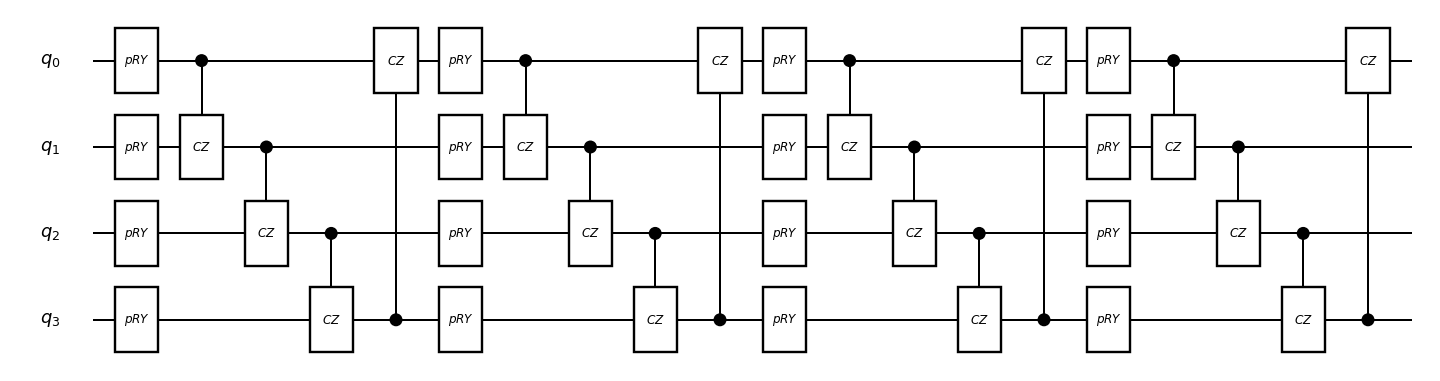

In [4]:
## まずはエラーなしの場合
from qulacsvis import circuit_drawer
from scipy.optimize import minimize

#状態ベクトル、ansatz回路を定義
n_qubits = 4
state = QuantumState(n_qubits)
circuit_depth = 4
circuit = ParametricQuantumCircuit(n_qubits)

#ansatz回路を指定
def Circuit(n_qubits,circuit_depth):
    circuit = ParametricQuantumCircuit(n_qubits)
    for d in range(circuit_depth):
        for i in range(n_qubits):
            circuit.add_parametric_RY_gate(i, 0.0)
        for i in range(n_qubits):
            circuit.add_CZ_gate(i, (i+1)%n_qubits)
    return circuit
circuit = Circuit(n_qubits,circuit_depth)
params = np.zeros(circuit.get_parameter_count())

#ansatz回路を表示
circuit_drawer(circuit, "mpl")

In [5]:
#コスト関数を定義。ここではエネルギー期待値がコスト関数。
def get_cost(params):
    state = QuantumState(n_qubits)
    for i, p in enumerate(params):
        circuit.set_parameter(i,p)
    circuit.update_quantum_state(state)
    return transverse_Ising_hamiltonian.get_expectation_value(state)

In [6]:
#上で定義したansatz回路のもとで、コスト関数を最小化する。
params_initial = np.zeros_like(params)
minimized_costfunction = minimize(get_cost, params_initial, method='BFGS')

#コスト関数の最小値を表示
print(minimized_costfunction.fun)

-5.072893485812115


In [7]:
#エラーがない場合のansatz回路のパラメータを取得
params_true = minimized_costfunction.x

## エラーありの場合

エラーがない場合のansatz回路のパラメータを取得し、各ゲートに以下のエラーを作用させます。

Depolarizing noise: $\mathcal{E}[\rho]=(1-p)\rho+\frac{p}{3} (X\rho X+Y\rho Y+Z\rho Z)$

In [8]:
## 次にdepolarizing noiseありの場合（１次元横磁場イジング模型）

#密度演算子、ansatz回路を定義
density_state = DensityMatrix(n_qubits)
noisy_circuit = ParametricQuantumCircuit(n_qubits)
error_rate = 0.01

#ansatz回路を指定
def NoisyCircuit(error_rate):
    noisy_circuit = ParametricQuantumCircuit(n_qubits)
    for d in range(circuit_depth):
        for i in range(n_qubits):
            noisy_circuit.add_parametric_RY_gate(i, 0.0)
            noisy_circuit.add_gate(DepolarizingNoise(i, error_rate))
        for i in range(n_qubits):
            noisy_circuit.add_CZ_gate(i, (i+1)%n_qubits)
            noisy_circuit.add_gate(DepolarizingNoise(i, error_rate))
            noisy_circuit.add_gate(DepolarizingNoise((i+1)%n_qubits, error_rate))
    return noisy_circuit

noisy_circuit = NoisyCircuit(error_rate)

In [9]:
#コスト関数を定義。ここではエネルギー期待値がコスト関数。
def noisy_get_cost(params):
    density_state = DensityMatrix(n_qubits)
    for i, p in enumerate(params):
        noisy_circuit.set_parameter(i,p)
    noisy_circuit.update_quantum_state(density_state)
    return transverse_Ising_hamiltonian.get_expectation_value(density_state)

In [10]:
#エラーなし、エラーありの場合で期待値を計算
minimized_costfunction_noiseless = get_cost(params_true)
minimized_costfunction_noise = noisy_get_cost(params_true)

#コスト関数の最小値を表示
print(minimized_costfunction_noiseless)
print(minimized_costfunction_noise)

-5.072893485812115
-3.8479591358366707


エラーの影響により、コスト関数の最小値が理想的な場合から遠ざかっていることが確認できます。

## エラーを変化させた場合
コスト関数の期待値のエラー率依存性を求めてみます。

In [11]:
data_cost_depolarizingnoise = []
data_noise_strength = []
data_error_rate_per_gate = []

#エラー率を少しずつ変化させて、コスト関数を求める。
for i in range(20):
    error_rate=i*0.001
    total_error_rate = error_rate * (3.0*n_qubits) * circuit_depth
    noisy_circuit = NoisyCircuit(error_rate)
    minimized_costfunction_noise = noisy_get_cost(params_true)
    data_cost_depolarizingnoise.append(minimized_costfunction_noise)
    data_noise_strength.append(total_error_rate)
    data_error_rate_per_gate.append(error_rate)

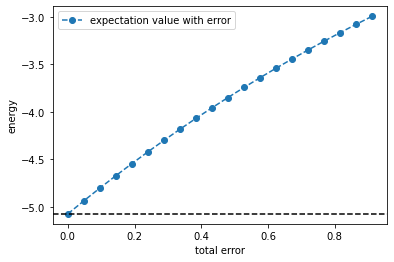

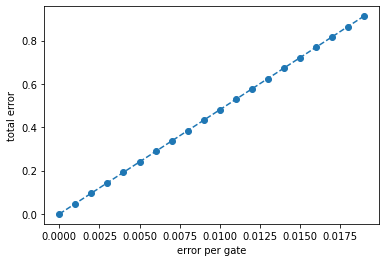

In [12]:
#コスト関数 vs （全ゲート数）×（エラー率）のグラフ
plt.plot(data_noise_strength,data_cost_depolarizingnoise, marker="o", linestyle = "--", label=f"expectation value with error")
plt.axhline(minimized_costfunction_noiseless, color="black", linestyle="dashed")
plt.ylabel("energy")
plt.xlabel("total error")
plt.legend()
plt.show()

#（全ゲート数）×（エラー率） vs エラー率のグラフ
plt.plot(data_error_rate_per_gate,data_noise_strength, marker="o", linestyle = "--")
plt.ylabel("total error")
plt.xlabel("error per gate")
plt.show()

ここで、total error = （全ゲート数）×（エラー率）としました。この値が１程度であれば、エラー補償は機能します。

## 外挿法（リチャードソン外挿・指数関数外挿）の実装
エラー率を增大させて、外挿法を実装してみます。

In [13]:
##error mitigation（外挿法）を実行する。リチャードソン外挿のうち、線形外挿をやってみる。
## ノイズに関するコスト関数のグラフ

data_cost_depolarizingnoise_alpha = []
data_cost_depolarizingnoise_linear_extrapolation = []
alpha = 1.5

for i in range(20):
    error_rate=i * 0.001 * alpha
    noisy_circuit = NoisyCircuit(error_rate)
    minimized_costfunction_noise = noisy_get_cost(params_true)
    data_cost_depolarizingnoise_alpha.append(minimized_costfunction_noise)

for i in range(20):
    linear_extrapolation = (alpha*data_cost_depolarizingnoise[i]-data_cost_depolarizingnoise_alpha[i])/(alpha - 1.0)
    data_cost_depolarizingnoise_linear_extrapolation.append(linear_extrapolation)

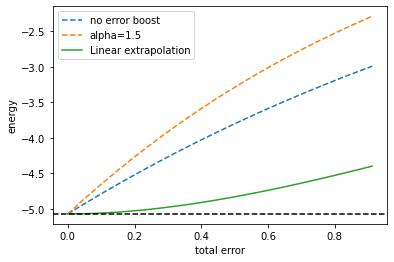

In [14]:
#線形外挿の結果を表示
plt.plot(data_noise_strength,data_cost_depolarizingnoise, label=f"no error boost",linestyle="dashed")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_alpha, label=f"alpha=1.5",linestyle="dashed")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_linear_extrapolation, label=f"Linear extrapolation")
plt.axhline(minimized_costfunction_noiseless, color="black", linestyle="dashed")
plt.ylabel("energy")
plt.xlabel("total error")
plt.legend()
plt.show()

In [15]:
##error mitigation（外挿法）を実行する　その２（２次多項式で外挿）
## ノイズに関するコスト関数のグラフ
data_cost_depolarizingnoise_alpha2 = []
data_cost_depolarizingnoise_Richardson_extrapolation = []

alpha1 = alpha
alpha2 = 2.0

for i in range(20):
    error_rate=i*0.001*alpha2
    noisy_circuit = NoisyCircuit(error_rate)
    minimized_costfunction_noise = noisy_get_cost(params_true)
    data_cost_depolarizingnoise_alpha2.append(minimized_costfunction_noise)

for i in range(20):
    beta0 = (alpha1/(alpha1 - 1.0))*(alpha2/(alpha2 - 1.0))
    beta1 = ((1.0)/(1.0-alpha1))*(alpha2/(alpha2 - alpha1))
    beta2 = ((1.0)/(1.0-alpha2))*(alpha1/(alpha1 - alpha2))
    Richardson_extrapolation = beta0*data_cost_depolarizingnoise[i]+beta1*data_cost_depolarizingnoise_alpha[i]+beta2*data_cost_depolarizingnoise_alpha2[i]
    data_cost_depolarizingnoise_Richardson_extrapolation.append(Richardson_extrapolation)

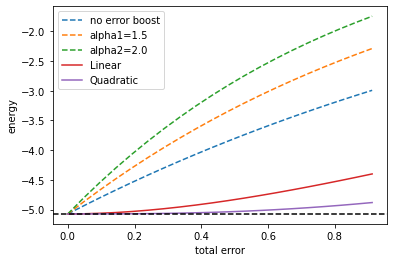

In [16]:
#実線が外挿した結果、点線はmitigationしていない結果
plt.plot(data_noise_strength,data_cost_depolarizingnoise, label=f"no error boost",linestyle="dashed")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_alpha, label=f"alpha1=1.5",linestyle="dashed")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_alpha2, label=f"alpha2=2.0",linestyle="dashed")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_linear_extrapolation, label=f"Linear")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_Richardson_extrapolation, label=f"Quadratic")
plt.axhline(minimized_costfunction_noiseless, color="black", linestyle="dashed")
plt.ylabel("energy")
plt.xlabel("total error")
plt.legend()
plt.show()

１次、２次の多項式で外挿しました。２次で外挿した場合が最もバイアスが小さいことが確認できました。
次に、指数関数外挿も実装します。指数関数外挿とリチャードソン外挿は、測定後のデータ処理の違いのみなので、すでに計算した結果を用います。

In [17]:
##error mitigation（指数関数外挿法）を実行する　その３
## ノイズに関するコスト関数のグラフ
##指数関数外挿とリチャードソン外挿は測定後のデータ処理の違いのみであることに注意

data_cost_depolarizingnoise_Exponential_extrapolation = []
data_cost_depolarizingnoise_Exponential_extrapolation_alpha2 = []

for i in range(20):
    Exponential_extrapolation = -np.abs(data_cost_depolarizingnoise[i])**(alpha1/(alpha1 - 1.0)) * np.abs(data_cost_depolarizingnoise_alpha[i])**(1.0/(1.0-alpha1))
    data_cost_depolarizingnoise_Exponential_extrapolation.append(Exponential_extrapolation)

for i in range(20):
    Exponential_extrapolation = -np.abs(data_cost_depolarizingnoise[i])**(alpha2/(alpha2 - 1.0)) * np.abs(data_cost_depolarizingnoise_alpha2[i])**(1.0/(1.0-alpha2))
    data_cost_depolarizingnoise_Exponential_extrapolation_alpha2.append(Exponential_extrapolation)

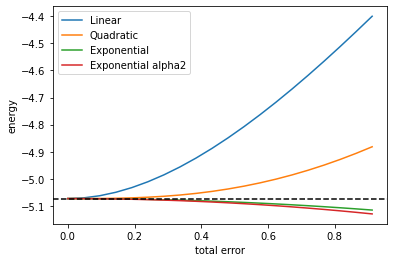

In [18]:
#それぞれ外挿した結果を表示
plt.plot(data_noise_strength,data_cost_depolarizingnoise_linear_extrapolation, label=f"Linear")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_Richardson_extrapolation, label=f"Quadratic")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_Exponential_extrapolation, label=f"Exponential")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_Exponential_extrapolation_alpha2, label=f"Exponential alpha2")
plt.axhline(minimized_costfunction_noiseless, color="black", linestyle="dashed")
plt.ylabel("energy")
plt.xlabel("total error")
plt.legend()
plt.show()

上の例では、指数関数外挿が最も良い結果になっていました。

## サンプリングで期待値を求める場合
`get_expectation_value`で期待値を求める代わりに、`sampling()`を使ってサンプリングから期待値を求めてみます。
その結果を利用して外挿法を実装してみると、エラー補償で分散が增大していることも確認できます。

In [19]:
#コスト関数の期待値をサンプリングから求める関数を定義
shots = 3000
def get_cost_sampling(shots,params):
    density_state = DensityMatrix(n_qubits)
    noisy_circuit = NoisyCircuit(error_rate)
    for i, p in enumerate(params):
        noisy_circuit.set_parameter(i,p)
    noisy_circuit.update_quantum_state(density_state)
    density_copy_ZZ = DensityMatrix(n_qubits)
    density_copy_X = DensityMatrix(n_qubits)
    density_copy_ZZ = density_state.copy()
    density_copy_X = density_state.copy()
    mask_list_ZZ = [0b1100,0b0110,0b0011,0b1001]
    mask_list_X = [0b1000,0b0100,0b0010,0b0001]    
    for i in range(n_qubits):
        gate = H(i)
        gate.update_quantum_state(density_copy_X)
    noise_sampling_ZZ = density_copy_ZZ.sampling(shots)
    noise_sampling_X = density_copy_X.sampling(shots)
    estimated_ZZ_average = 0.0
    estimated_X_average = 0.0
    for s in noise_sampling_ZZ:
        for mask in mask_list_ZZ:
            bitcount = bin(s & mask).count("1")
            estimated_ZZ_average += (-1)**bitcount/shots
    for s in noise_sampling_X:
        for mask in mask_list_X:
            bitcount = bin(s & mask).count("1")
            estimated_X_average += (-1)**bitcount/shots
    data_sampling_average = h * estimated_X_average + J * estimated_ZZ_average
    return data_sampling_average

In [20]:
#エラーを変化させて、期待値をサンプリングから求める。
data_cost_depolarizingnoise_sampling1 = []
data_cost_depolarizingnoise_sampling2 = []
data_cost_depolarizingnoise_sampling_linear_extrapolation = []
data_cost_depolarizingnoise_sampling_Exponential_extrapolation = []
alpha = 2.0

#エラーありの期待値（サンプリングで求める）
for i in range(20):
    error_rate=i*0.001
    density_state = DensityMatrix(n_qubits)
    noisy_circuit = NoisyCircuit(error_rate)
    minimized_costfunction_noise = get_cost_sampling(shots,params_true)
    data_cost_depolarizingnoise_sampling1.append(minimized_costfunction_noise)

#エラーをα倍だけ増幅させたときの期待値（サンプリングで求める）
for i in range(20):
    error_rate=i*0.001*alpha
    density_state = DensityMatrix(n_qubits)
    noisy_circuit = NoisyCircuit(error_rate)
    minimized_costfunction_noise = get_cost_sampling(shots,params_true)
    data_cost_depolarizingnoise_sampling2.append(minimized_costfunction_noise)

#サンプリングで求めた期待値を使って線形外挿
for i in range(20):
    linear_extrapolation = (alpha*data_cost_depolarizingnoise_sampling1[i]-data_cost_depolarizingnoise_sampling2[i])/(alpha - 1.0)
    data_cost_depolarizingnoise_sampling_linear_extrapolation.append(linear_extrapolation)

#サンプリングで求めた期待値を使って指数関数外挿
for i in range(20):  
    Exponential_extrapolation_sampling = -np.abs(data_cost_depolarizingnoise_sampling1[i])**(alpha/(alpha - 1.0)) * np.abs(data_cost_depolarizingnoise_sampling2[i])**(1.0/(1.0-alpha))
    data_cost_depolarizingnoise_sampling_Exponential_extrapolation.append(Exponential_extrapolation_sampling)

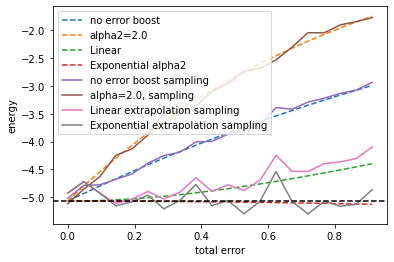

In [21]:
#厳密な期待値を使った結果と、サンプリングを使った結果をそれぞれグラフに表示させる
plt.plot(data_noise_strength,data_cost_depolarizingnoise, label=f"no error boost",linestyle="dashed")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_alpha2, label=f"alpha2=2.0",linestyle="dashed")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_linear_extrapolation, label=f"Linear",linestyle="dashed")
#plt.plot(data_noise_strength,data_cost_depolarizingnoise_Richardson_extrapolation, label=f"Quadratic")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_Exponential_extrapolation_alpha2, label=f"Exponential alpha2",linestyle="dashed")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_sampling1, label=f"no error boost sampling")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_sampling2, label=f"alpha=2.0, sampling")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_sampling_linear_extrapolation, label=f"Linear extrapolation sampling")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_sampling_Exponential_extrapolation, label=f"Exponential extrapolation sampling")
plt.axhline(minimized_costfunction_noiseless, color="black", linestyle="dashed")
plt.ylabel("energy")
plt.xlabel("total error")
plt.legend()
plt.show()

測定回数$3000\times 2$の場合について計算してみました。点線が期待値そのもの、実線がサンプリングした場合を表しています。error mitigationした結果はエラー率が増大するにつれ、分散が増大していることが確認できます。この分散を抑えるためには、測定回数を増やす必要があります。

In [22]:
#エラー率を固定して、ヒストグラムを作成
error_rate = 0.02
n_test = 1000
shots = 1000
alpha1 = 1.3
total_error_rate = error_rate * (3.0*n_qubits) * circuit_depth
no_mitigation_list = np.zeros(n_test)
error_boost_list = np.zeros(n_test)
linear_mitigated_list = np.zeros(n_test)
exponential_mitigated_list = np.zeros(n_test)
for i in range(n_test):
    density_state = DensityMatrix(n_qubits)
    noisy_circuit = NoisyCircuit(error_rate)
    no_mitigation_list[i] = get_cost_sampling(shots,params_true)
expec_value = noisy_get_cost(params_true)
error_rate = error_rate *alpha1
for i in range(n_test):
    density_state = DensityMatrix(n_qubits)
    noisy_circuit = NoisyCircuit(error_rate*alpha1)
    error_boost_list[i] = get_cost_sampling(shots,params_true)
for i in range(n_test):
    linear_mitigated_list[i] = (alpha1*no_mitigation_list[i]-error_boost_list[i])/(alpha1 - 1.0)
    exponential_mitigated_list[i] = - np.abs(no_mitigation_list[i])**(alpha1/(alpha1 - 1.0)) * np.abs(error_boost_list[i])**(1.0/(1.0-alpha1))

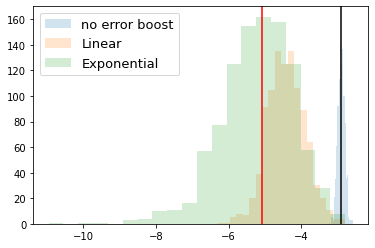

In [23]:
plt.hist(no_mitigation_list, alpha=0.2, bins=20, label=f"no error boost")
plt.hist(linear_mitigated_list, alpha=0.2, bins=20, label=f"Linear")
plt.hist(exponential_mitigated_list, alpha=0.2, bins=20, label=f"Exponential")
plt.axvline(expec_value, color="black")
plt.axvline(get_cost(params_true), color="red")
plt.legend(loc="upper left", fontsize=13)
plt.show()

エラー率を固定して、ヒストグラムを作成した結果です。
指数関数外挿が最もエラーを抑制できていることが分かります。
一方で、分散もそのぶん増大していることも分かります。

In [24]:
#得られたヒストグラムから、それぞれの標準偏差を求めてみる。標準偏差の比から測定コストが求まる。
std_no_mitigation = np.std(no_mitigation_list)
std_linear_extrapolation = np.std(linear_mitigated_list)
std_exponential_extrapolation = np.std(exponential_mitigated_list)

In [25]:
#理論的に見積もられる測定コスト
cost_linear_extrapolation = np.sqrt((alpha1/(alpha1 - 1.0))**2 + (1.0/(alpha1 - 1.0))**2)
cost_exponential_extrapolation = np.sqrt((alpha1/(alpha1 - 1.0)*np.exp(total_error_rate))**2 + (1.0/(alpha1 - 1.0)*np.exp(alpha1*total_error_rate))**2)

In [26]:
#実際に得られた標準偏差と、コストの見積もりの比較・線形外挿
print(std_linear_extrapolation/std_no_mitigation)
print(cost_linear_extrapolation)

5.50027198540011
5.467073155618908


In [27]:
#実際に得られた標準偏差と、コストの見積もりの比較・指数関数外挿
print(std_exponential_extrapolation/std_no_mitigation)
print(cost_exponential_extrapolation)

10.788841437046047
16.214287639163235


見積もられる測定コストは、リチャードソン外挿・指数関数外挿どちらも同じような値になることが分かりました。